# Supervisely Tutorial #2

# Online API basics: organize and explore workspaces, projects and neural networks 

In this tutorial we will cover the basics of how to script your interactions with the Supervisely web instance using our online API.

You will learn how to query the web instance for existing projects and datasets, get and update their metadata and download images and their labeling data locally for further processing with our Python SDK. You will also see how to add an existing neural network from our public repository, read off its metainformation and download the weights and inference confi locally.

In the follow up tutorials (#4 and #5) you will learn how to request neural net inference from the web instance and how to automate complex data processing pipelines using Supervisely workflows.

### Necessary imports

In [1]:
import supervisely_lib as sly

# PyPlot only for rendering images inside Jupyter.
%matplotlib inline
import matplotlib.pyplot as plt

## Initialize API access with your credentials

Before starting to interact with a Supervisely web instance using our API, you need to supply your use credentials: your unique access token that you can find under your profile details:

In [2]:
import os

# Jupyter notebooks hosted on Supervisely can get their user's
# credentials from the environment varibales.
# If you are running the notebook outside of Supervisely, plug
# the server address and your API token here.
# You can find your API token in the account settings:
# -> click your name in the top-right corner
# -> select "account settings"
# -> select "API token" tab on top.
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

print("Server address: ", address)
print("Your API token: ", token)

# Initialize the API access object.
api = sly.Api(address, token)

Server address:  http://192.168.1.69:5555
Your API token:  OfaV5z24gEQ7ikv2DiVdYu1CXZhMavU7POtJw2iDtQtvGUux31DUyWTXW6mZ0wd3IRuXTNtMFS9pCggewQWRcqSTUi4EJXzly8kH7MJL1hm3uZeM2MCn5HaoEYwXejKT


## Workspace management

In Supervisely, workspaces are the top level groups of your work items. Each workspace contains plugins, such as neural network implementations and projects with datasets.

Let us start with listing all the existing workspaces:

In [3]:
# In Supervisely, a user can belong to multiple teams.
# Everyone has a default team with just their user in it.
# We will work in the context of that default team.
team = api.team.get_list()[0]

# Query for all the workspaces in the selected team
workspaces = api.workspace.get_list(team.id)
print("Team {!r} contains {} workspaces:".format(team.name, len(workspaces)))
for workspace in workspaces:
    print("{:<8}{:<15s}".format(workspace.id, workspace.name))

Team 'max' contains 22 workspaces:
9    my_super_workspace_002
10   region_pipeline
34   script1        
35   dtl_bug        
39   script2        
40   train_test     
41   ws7            
44   dfgd           
45   test_dtl_segmentation
55   my_super_workspace
56   test_workspace_001
57   test_workspace_002
58   test_api       
60   test_api2      
67   my_super_workspace_001
69   test_workspace 
82   tutorial_04    
83   tutorial_05_backup
84   tutorial_05    
90   my_super_workspace_003
92   test_new       
111  test_fast_agent


We can quickly read off more details on the workspace, like the description, creation and last modification times:

In [4]:
print(workspaces[0])

WorkspaceInfo(id=9, name='my_super_workspace_002', description='super workspace description', team_id=9, created_at='2019-01-20T13:25:19.142Z', updated_at='2019-01-20T13:25:19.142Z')


For this tutorial, we will create a new workspace to avoid interfering with any existing work.

In [5]:
workspace_name = 'tutorial_workspace'

# Just in case there is already a workspace with this name,
# we can ask the web instance for a new unique name to use.
if api.workspace.exists(team.id, workspace_name):
    workspace_name = api.workspace.get_free_name(team.id, workspace_name)

# Create the workspace and print out its metadata.
workspace = api.workspace.create(team.id, workspace_name, 'tutorial workspace description')
print(workspace)

WorkspaceInfo(id=114, name='tutorial_workspace', description='tutorial workspace description', team_id=9, created_at='2019-04-07T15:59:02.645Z', updated_at='2019-04-07T15:59:02.645Z')


We can query for workspace metadata both by workspace name and by numeric ID:

In [6]:
workspace_by_name = api.workspace.get_info_by_name(team.id, workspace_name)
print(workspace_by_name)
print()

workspace_by_id = api.workspace.get_info_by_id(workspace.id)
print(workspace_by_id)

WorkspaceInfo(id=114, name='tutorial_workspace', description='tutorial workspace description', team_id=9, created_at='2019-04-07T15:59:02.645Z', updated_at='2019-04-07T15:59:02.645Z')

WorkspaceInfo(id=114, name='tutorial_workspace', description='tutorial workspace description', team_id=9, created_at='2019-04-07T15:59:02.645Z', updated_at='2019-04-07T15:59:02.645Z')


Both workspace name and description can be changed later:

In [7]:
# update workspace name, description, or both
new_name = 'my_super_workspace'
new_description = 'super workspace description'
if api.workspace.exists(team.id, new_name):
    new_name = api.workspace.get_free_name(team.id, new_name)

print("Before update: {}\n".format(workspace))
    
workspace = api.workspace.update(workspace.id, new_name, new_description)

print("After  update: {}".format(workspace))

Before update: WorkspaceInfo(id=114, name='tutorial_workspace', description='tutorial workspace description', team_id=9, created_at='2019-04-07T15:59:02.645Z', updated_at='2019-04-07T15:59:02.645Z')

After  update: WorkspaceInfo(id=114, name='my_super_workspace_004', description='super workspace description', team_id=9, created_at='2019-04-07T15:59:02.645Z', updated_at='2019-04-07T15:59:02.645Z')


## Project management

A project is a group of datasets with common labeling metadata (the set of available classes and tags). For example, one can have a project of labeled road scenes (so the taxonomy of the classes will relate to vehicles, pedestrians and road signs), and inside the project have a separate dataset for every day on which the data was collected.

We will start populating our new workspace by cloning one of the publically available in Supervisely projects into it.

In [8]:
# 'lemons_annotated' is one of our out of the box demo projects, so
# we will make a copy with the appropriate name.
project_name = 'lemons_annotated_clone'
if api.project.exists(workspace.id, project_name):
    project_name = api.project.get_free_name(workspace.id, project_name)

task_id = api.project.clone_from_explore('Supervisely/Demo/lemons_annotated', workspace.id, project_name)

# The clone call returns immediately, so the code does not
# have to block on waiting for the task to complete.
# Since we do not have much to do in the meantime, just wait for the task.
api.task.wait(task_id, api.task.Status.FINISHED)

# Now that the task has finished we can query for the project metadata.
project = api.project.get_info_by_name(workspace.id, project_name)
print("Project {!r} has been sucessfully cloned from explore: ".format(project.name))
print(project)

Project 'lemons_annotated_clone' has been sucessfully cloned from explore: 
ProjectInfo(id=1276, name='lemons_annotated_clone', description='', size='861069', readme='', workspace_id=114, created_at='2019-04-07T15:59:08.975Z', updated_at='2019-04-07T15:59:08.975Z')


Now we have a project in the new workspace, let us make sure there is only one. Query and print out the projects in the workspace:

In [9]:
projects = api.project.get_list(workspace.id)
print("Workspace {!r} contains {} projects:".format(workspace.name, len(projects)))
for project in projects:
    print("{:<5}{:<15s}".format(project.id, project.name))

Workspace 'my_super_workspace_004' contains 1 projects:
1276 lemons_annotated_clone


We can query project metadata both by project name and by numeric id:

In [10]:
# Get project info by name
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    print("Workspace {!r} not found".format(project_name))
else:
    print(project)
print()

# Get project info by id.
project = api.project.get_info_by_id(project.id)
if project is None:
    print("Project with id={!r} not found".format(some_project_id))
else:
    print(project)

ProjectInfo(id=1276, name='lemons_annotated_clone', description='', size='861069', readme='', workspace_id=114, created_at='2019-04-07T15:59:08.975Z', updated_at='2019-04-07T15:59:08.975Z')

ProjectInfo(id=1276, name='lemons_annotated_clone', description='', size='861069', readme='', workspace_id=114, created_at='2019-04-07T15:59:08.975Z', updated_at='2019-04-07T15:59:08.975Z')


Separately we can query for the number of datasets in a project, and for the number of images in a dataset:

In [11]:
# get number of datasets and images in project
datasets_count = api.project.get_datasets_count(project.id)
images_count = api.project.get_images_count(project.id)
print("Project {!r} contains:\n {} datasets \n {} images\n".format(project.name, datasets_count, images_count))

Project 'lemons_annotated_clone' contains:
 1 datasets 
 6 images



Get the labeling meta information for the projects - the set of available object classes and tags. We get back a serialized project meta, which can be conveniently parsed into a `ProjectMeta` object from our Python SDK. See our tutorial #1 for a detailed guide on how to work with projects metadata using the SDK.

In [12]:
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)
print(meta)

ProjectMeta:
Object Classes
+-------+--------+----------------+
|  Name | Shape  |     Color      |
+-------+--------+----------------+
|  kiwi | Bitmap |  [255, 0, 0]   |
| lemon | Bitmap | [81, 198, 170] |
+-------+--------+----------------+
Image Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+
Object Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



List the datasets from the given project:

In [13]:
datasets = api.dataset.get_list(project.id)
print("Project {!r} contains {} datasets:".format(project.name, len(datasets)))
for dataset in datasets:
    print("Id: {:<5} Name: {:<15s} images count: {:<5}".format(dataset.id, dataset.name, dataset.images_count))

Project 'lemons_annotated_clone' contains 1 datasets:
Id: 1717  Name: ds1             images count: 6    


List all the images for a given dataset, their sizes, dimensions and the number of labeled objects:

In [14]:
dataset = datasets[0]
images = api.image.get_list(dataset.id)
print("Dataset {!r} contains {} images:".format(dataset.name, len(images)))
for image in images:
    print("Id: {:<5} Name: {:<15s} labels count: {:<5} size(bytes): {:<10} width: {:<5} height: {:<5}"
          .format(image.id, image.name, image.labels_count, image.size, image.width, image.height))

Dataset 'ds1' contains 6 images:
Id: 146018 Name: IMG_0748.jpeg   labels count: 3     size(bytes): 155790     width: 1067  height: 800  
Id: 146019 Name: IMG_1836.jpeg   labels count: 3     size(bytes): 140222     width: 1067  height: 800  
Id: 146020 Name: IMG_3861.jpeg   labels count: 4     size(bytes): 148388     width: 1067  height: 800  
Id: 146021 Name: IMG_4451.jpeg   labels count: 5     size(bytes): 135689     width: 1067  height: 800  
Id: 146022 Name: IMG_2084.jpeg   labels count: 7     size(bytes): 142097     width: 1067  height: 800  
Id: 146023 Name: IMG_8144.jpeg   labels count: 4     size(bytes): 138883     width: 1067  height: 800  


Download an image along with its annotation (all the labeling information for that image):

Image Shape: (800, 1067, 3)


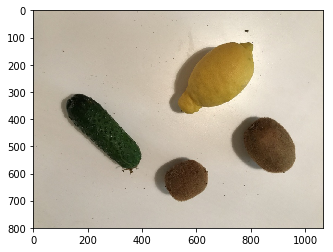

In [15]:
# Download and display the image.
image = images[0]
img = api.image.download_np(image.id)
print("Image Shape: {}".format(img.shape))
imgplot = plt.imshow(img)

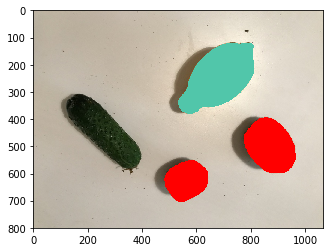

In [16]:
# Download the serialized JSON annotation for the image.
ann_info = api.annotation.download(image.id)
# Parse the annotation using the Supervisely Python SDK
# and instantiate convenience wrappers for the objects in the annotation.
ann = sly.Annotation.from_json(ann_info.annotation, meta)

# Render the object labels on top of the original image.
img_with_ann = img.copy()
ann.draw(img_with_ann)
imgplot = plt.imshow(img_with_ann)

## Neural network management

Here we will only cover working with neural networks metadata. There is a separate tutorial (Supervisely Tutorial #4) on running neural network training and inference.

First, we will clone one of the existing publically avaliable in Supervisely models into our workspace:

In [17]:
# Set the destination model name within our workspace
model_name = 'yolo_coco'

# Grab a unique name in case the one we chose initially is busy.
if api.model.exists(workspace.id, model_name):
    model_name = api.model.get_free_name(workspace.id, model_name)

# Request the model to be copied from our public repository.
# This kicks off an asynchronous task.
task_id = api.model.clone_from_explore('Supervisely/Model Zoo/YOLO v3 (COCO)', workspace.id, model_name)

# Wait for the copying to complete.
api.task.wait(task_id, api.task.Status.FINISHED)

# Query the metadata for the copied model.
model = api.model.get_info_by_name(workspace.id, model_name)
print("Model {!r} has been sucessfully cloned from explore: ".format(model.name))
print(model)

Model 'yolo_coco' has been sucessfully cloned from explore: 
ModelInfo(id=360, name='yolo_coco', description='Trained on COCO. Can be used for both training and inference', config=None, hash='0/o/I7/TaFtVZ8Yk5JXHkBaI9HRTbfqQglvvC7rW8yDqRcFmictKTNsu5oGDxfkVgkVHZ34rFn4dZgVEEexjEjrRcR1pIl2voLTgzKTf5nDRCHEMJLAWleyzFZVJrUEMg3R.tar', only_train=False, plugin_id=6, plugin_version='latest', size='248027648', weights_location='uploaded', readme='', task_id=None, user_id=9, team_id=9, workspace_id=114, created_at='2019-04-07T15:59:28.334Z', updated_at='2019-04-07T15:59:28.334Z')


We can also download locally the model weights and config (which describes the set of classes the model would predict) as a .tar file:

In [18]:
api.model.download_to_tar(workspace.id, model.name, './model.tar')